# Introduction

In this notebook, we perform **GI tract semantic image segmentation** using U-Net. 

**Libraries**

In [1]:
# Core
import pandas as pd
import numpy as np
import os
import cv2
import gc
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.notebook import tqdm
from datetime import datetime
import json,itertools
from typing import Optional
from glob import glob
import warnings
warnings.filterwarnings("ignore")
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold
import random

# Keras
from tensorflow import keras
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from tensorflow.keras.layers import concatenate 
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras.models import load_model, save_model

**Reproducibility**

In [2]:
# Set random seeds
def set_seed(seed=0):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
set_seed()

**Config**

In [3]:
BATCH_SIZE = 16
EPOCHS = 40
n_splits = 5
fold_selected = 2   # 1,...,5
im_width = 320
im_height = 320

# Data

**Train set**

In [4]:
# Train set
train_df = pd.read_csv('/Users/yunjaewon/tensorflow/uw-madison-gi-tract-image-segmentation/train.csv')
print(train_df.shape)
train_df.head()

(115488, 3)


,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


**Test set**

*Note:* This is a code competition, which means the 'real' test set will be populated at inference time.

In [5]:
# Test set
test_df = pd.read_csv('/Users/yunjaewon/tensorflow/uw-madison-gi-tract-image-segmentation/sample_submission.csv')

if len(test_df)==0:
    DEBUG=True
    test_df = train_df.iloc[:10*16*3,:]
    test_df["segmentation"]=''
    test_df=test_df.rename(columns={"segmentation":"predicted"})
else:
    DEBUG=False

submission=test_df.copy()
test_df.head()

,id,class,predicted
0,case123_day20_slice_0001,large_bowel,
1,case123_day20_slice_0001,small_bowel,
2,case123_day20_slice_0001,stomach,
3,case123_day20_slice_0002,large_bowel,
4,case123_day20_slice_0002,small_bowel,


# Preprocessing

**Metadata**

In [6]:
# Metadata
def preprocessing(df, subset="train"):
    #--------------------------------------------------------------------------
    df["case"] = df["id"].apply(lambda x: int(x.split("_")[0].replace("case", "")))
    df["day"] = df["id"].apply(lambda x: int(x.split("_")[1].replace("day", "")))
    df["slice"] = df["id"].apply(lambda x: x.split("_")[3])
    #--------------------------------------------------------------------------
    if (subset=="train") or (DEBUG):
        DIR="/Users/yunjaewon/tensorflow/uw-madison-gi-tract-image-segmentation/train"
    else:
        DIR="/Users/yunjaewon/tensorflow/uw-madison-gi-tract-image-segmentation/test"
    
    all_images = glob(os.path.join(DIR, "**", "*.png"), recursive=True)
    x = all_images[0].rsplit("/", 4)[0] ## ../input/uw-madison-gi-tract-image-segmentation/train

    path_partial_list = []
    for i in range(0, df.shape[0]):
        path_partial_list.append(os.path.join(x,
                              "case"+str(df["case"].values[i]),
                              "case"+str(df["case"].values[i])+"_"+ "day"+str(df["day"].values[i]),
                              "scans",
                              "slice_"+str(df["slice"].values[i])))
    df["path_partial"] = path_partial_list
    #--------------------------------------------------------------------------
    path_partial_list = []
    for i in range(0, len(all_images)):
        path_partial_list.append(str(all_images[i].rsplit("_",4)[0]))

    tmp_df = pd.DataFrame()
    tmp_df['path_partial'] = path_partial_list
    tmp_df['path'] = all_images

    #--------------------------------------------------------------------------
    df = df.merge(tmp_df, on="path_partial").drop(columns=["path_partial"])
    #--------------------------------------------------------------------------
    df["width"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[1]))
    df["height"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[2]))
    #--------------------------------------------------------------------------
    del x, path_partial_list, tmp_df
    #--------------------------------------------------------------------------
    
    return df

In [7]:
train_df = preprocessing(train_df, subset="train")
train_df.head()

,id,class,segmentation,case,day,slice,path,width,height
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001,/Users/yunjaewon/tensorflow/uw-madison-gi-trac...,266,266
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001,/Users/yunjaewon/tensorflow/uw-madison-gi-trac...,266,266
2,case123_day20_slice_0001,stomach,NaN,123,20,0001,/Users/yunjaewon/tensorflow/uw-madison-gi-trac...,266,266
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002,/Users/yunjaewon/tensorflow/uw-madison-gi-trac...,266,266
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002,/Users/yunjaewon/tensorflow/uw-madison-gi-trac...,266,266


In [8]:
test_df=preprocessing(test_df, subset="test")
test_df.head()

,id,class,predicted,case,day,slice,path,width,height
0,case123_day20_slice_0001,large_bowel,,123,20,0001,/Users/yunjaewon/tensorflow/uw-madison-gi-trac...,266,266
1,case123_day20_slice_0001,small_bowel,,123,20,0001,/Users/yunjaewon/tensorflow/uw-madison-gi-trac...,266,266
2,case123_day20_slice_0001,stomach,,123,20,0001,/Users/yunjaewon/tensorflow/uw-madison-gi-trac...,266,266
3,case123_day20_slice_0002,large_bowel,,123,20,0002,/Users/yunjaewon/tensorflow/uw-madison-gi-trac...,266,266
4,case123_day20_slice_0002,small_bowel,,123,20,0002,/Users/yunjaewon/tensorflow/uw-madison-gi-trac...,266,266


**Restructure df**

In [9]:
# Restructure
def restructure(df, subset="train"):
    # RESTRUCTURE  DATAFRAME
    df_out = pd.DataFrame({'id': df['id'][::3]})

    if subset=="train":
        df_out['large_bowel'] = df['segmentation'][::3].values
        df_out['small_bowel'] = df['segmentation'][1::3].values
        df_out['stomach'] = df['segmentation'][2::3].values

    df_out['path'] = df['path'][::3].values
    df_out['case'] = df['case'][::3].values
    df_out['day'] = df['day'][::3].values
    df_out['slice'] = df['slice'][::3].values
    df_out['width'] = df['width'][::3].values
    df_out['height'] = df['height'][::3].values

    df_out=df_out.reset_index(drop=True)
    df_out=df_out.fillna('')
    if subset=="train":
        df_out['count'] = np.sum(df_out.iloc[:,1:4]!='',axis=1).values
    
    return df_out

In [10]:
train_df=restructure(train_df, subset="train")
train_df.head()

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,count
0,case123_day20_slice_0001,,,,/Users/yunjaewon/tensorflow/uw-madison-gi-trac...,123,20,0001,266,266,0
1,case123_day20_slice_0002,,,,/Users/yunjaewon/tensorflow/uw-madison-gi-trac...,123,20,0002,266,266,0
2,case123_day20_slice_0003,,,,/Users/yunjaewon/tensorflow/uw-madison-gi-trac...,123,20,0003,266,266,0
3,case123_day20_slice_0004,,,,/Users/yunjaewon/tensorflow/uw-madison-gi-trac...,123,20,0004,266,266,0
4,case123_day20_slice_0005,,,,/Users/yunjaewon/tensorflow/uw-madison-gi-trac...,123,20,0005,266,266,0


In [11]:
test_df=restructure(test_df, subset="test")
test_df.head()

,id,path,case,day,slice,width,height
0,case123_day20_slice_0001,/Users/yunjaewon/tensorflow/uw-madison-gi-trac...,123,20,0001,266,266
1,case123_day20_slice_0002,/Users/yunjaewon/tensorflow/uw-madison-gi-trac...,123,20,0002,266,266
2,case123_day20_slice_0003,/Users/yunjaewon/tensorflow/uw-madison-gi-trac...,123,20,0003,266,266
3,case123_day20_slice_0004,/Users/yunjaewon/tensorflow/uw-madison-gi-trac...,123,20,0004,266,266
4,case123_day20_slice_0005,/Users/yunjaewon/tensorflow/uw-madison-gi-trac...,123,20,0005,266,266


**Remove mislabelled data**

In [12]:
# Remove mislabeled training data
train_df = train_df[(train_df['case']!=7)|(train_df['day']!=0)].reset_index(drop=True)
train_df = train_df[(train_df['case']!=81)|(train_df['day']!=30)].reset_index(drop=True)

In [13]:
# Garbage collection
gc.collect()

22

# Helper functions

**RLE encoding**

In [14]:
# Run-length encoding
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)

**Metrics**

In [15]:
# Metrics
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + dice_loss(tf.cast(y_true, tf.float32), y_pred)

**Data generator**

In [16]:
# Images reshaped to (im_height,im_width)
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size = BATCH_SIZE, subset="train", shuffle=False):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.indexes = np.arange(len(df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        X = np.empty((self.batch_size,im_height,im_width,3))
        y = np.empty((self.batch_size,im_height,im_width,3))
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i, img_path in enumerate(self.df['path'].iloc[indexes]):
            w=self.df['width'].iloc[indexes[i]]
            h=self.df['height'].iloc[indexes[i]]
            img = self.__load_grayscale(img_path)  # shape: (im_height,im_width,1)
            X[i,] = img   # broadcast to shape: (im_height,im_width,3)
            if self.subset == 'train':
                for k,j in enumerate(["large_bowel","small_bowel","stomach"]):
                    rles = self.df[j].iloc[indexes[i]]
                    mask = rle_decode(rles, shape=(h, w, 1))
                    mask = cv2.resize(mask, (im_height,im_width))
                    y[i,:,:,k] = mask
        if self.subset == 'train':
            return X, y
        else: 
            return X
        
        # To do: add data augmentation
        
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_ANYDEPTH)
        dsize = (im_height,im_width)
        img = cv2.resize(img, dsize)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)
        return img

# EDA

**Target distribution**

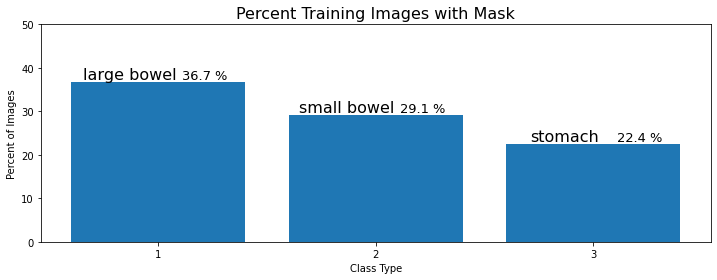

In [17]:
plt.figure(figsize=(12,4))
bar = plt.bar([1,2,3],100*np.mean(train_df.iloc[:,1:4]!='',axis=0))
plt.title('Percent Training Images with Mask', fontsize=16)
plt.ylabel('Percent of Images'); plt.xlabel('Class Type')
plt.xticks([1,2,3])
labels=["large bowel","small bowel","stomach"]
for rect, lbl in zip(bar, labels):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/3, height,  lbl,
             ha='center', va='bottom',fontsize=16)
    plt.text(rect.get_x() + rect.get_width()/1.3, height, '%.1f %%' % height,
             ha='center', va='bottom',fontsize=13)

plt.ylim((0,50))
plt.show()

**Preview some samples**

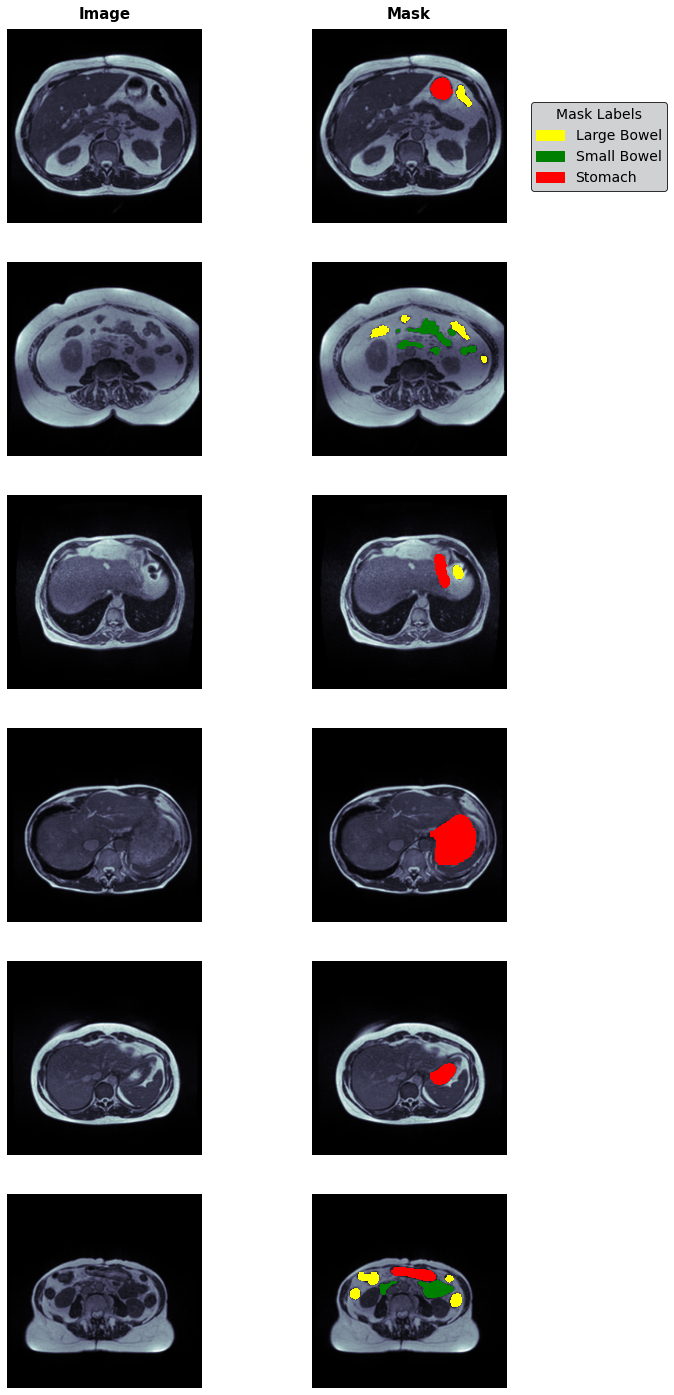

In [18]:
# SAMPLES
Masks = list(train_df[train_df['large_bowel']!=''].sample(BATCH_SIZE).index)
Masks += list(train_df[train_df['small_bowel']!=''].sample(BATCH_SIZE*2).index)
Masks += list(train_df[train_df['stomach']!=''].sample(BATCH_SIZE*3).index)

# DATA GENERATOR
View_batches = DataGenerator(train_df[train_df.index.isin(Masks)],shuffle=True)

# Visualizing
fig = plt.figure(figsize=(10, 25))
gs = gridspec.GridSpec(nrows=6, ncols=2)
colors = ['yellow','green','red']
labels = ["Large Bowel", "Small Bowel", "Stomach"]
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

cmap1 = mpl.colors.ListedColormap(colors[0])
cmap2 = mpl.colors.ListedColormap(colors[1])
cmap3= mpl.colors.ListedColormap(colors[2])

for i in range(6):
    images, mask = View_batches[i]
    sample_img=images[0,:,:,0]
    mask1=mask[0,:,:,0]
    mask2=mask[0,:,:,1]
    mask3=mask[0,:,:,2]
    
    ax0 = fig.add_subplot(gs[i, 0])
    im = ax0.imshow(sample_img, cmap='bone')

    ax1 = fig.add_subplot(gs[i, 1])
    if i==0:
        ax0.set_title("Image", fontsize=15, weight='bold', y=1.02)
        ax1.set_title("Mask", fontsize=15, weight='bold', y=1.02)
        plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 14,title='Mask Labels', title_fontsize=14, edgecolor="black",  facecolor='#c5c6c7')

    l0 = ax1.imshow(sample_img, cmap='bone')
    l1 = ax1.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=cmap1, alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(mask2== False,  mask2),cmap=cmap2, alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(mask3== False,  mask3),cmap=cmap3, alpha=1)
    _ = [ax.set_axis_off() for ax in [ax0,ax1]]

    colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]

# Cross-validation

**Group k-fold**

In [19]:
# Group by case id
skf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (_, val_idx) in enumerate(skf.split(X=train_df, y=train_df['count'], groups=train_df['case']), 1):
    train_df.loc[val_idx, 'fold'] = fold

train_df['fold'] = train_df['fold'].astype(np.uint8)

train_ids = train_df[train_df["fold"]!=fold_selected].index
valid_ids = train_df[train_df["fold"]==fold_selected].index

X_train = train_df[train_df.index.isin(train_ids)]
X_valid = train_df[train_df.index.isin(valid_ids)]

train_df.groupby('fold').size()

fold
1    8496
2    7136
3    7392
4    8128
5    7056
dtype: int64

In [20]:
# Fold sizes
train_df.groupby(['fold','count'])['id'].count()

fold  count
1     0        5023
      1         504
      2        2274
      3         695
2     0        4140
      1         353
      2        1998
      3         645
3     0        4164
      1         552
      2        2105
      3         571
4     0        4430
      1         598
      2        2390
      3         710
5     0        3958
      1         449
      2        2096
      3         553
Name: id, dtype: int64

**Debugging**

In [21]:
# Check submission format works
experimental=False
if experimental:
    X_train=X_train[X_train.case.isin(X_train.case.unique()[:5])]       # take first few cases
    X_valid=X_valid[X_valid.case.isin(X_valid.case.unique()[:2])]       # take first few cases
    
print('X_train shape:', X_train.shape)
print('X_valid shape:', X_valid.shape)

X_train shape: (31072, 12)
X_valid shape: (7136, 12)


**Define generator**

In [22]:
train_generator = DataGenerator(X_train, shuffle=True)
val_generator = DataGenerator(X_valid)

# U-Net model

**Download U-Net**

In [23]:
! pip install segmentation-models

In [24]:
! pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /private/var/folders/1_/5tg37fkx1n95d8xz5vrnx2n40000gn/T/pip-req-build-2y3z0aq8
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models /private/var/folders/1_/5tg37fkx1n95d8xz5vrnx2n40000gn/T/pip-req-build-2y3z0aq8
  Resolved https://github.com/qubvel/segmentation_models to commit e951c6747f75fa9e7240816d1c79dd2e66813123
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done


In [25]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

**Define model**

In [26]:
from segmentation_models import Unet
from segmentation_models.utils import set_trainable

model = Unet('resnet34',input_shape=(im_height, im_width, 3), classes=3, activation='sigmoid', encoder_weights='imagenet')
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef,iou_coef])

Metal device set to: Apple M1 Pro


2022-08-01 14:03:01.039004: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-01 14:03:01.039134: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [27]:
# Model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 320, 320, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 326, 326, 3)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 160, 160, 64  9408        ['zero_padding2d[0][0]']   

 D)                                                                                               
                                                                                                  
 stage1_unit3_conv1 (Conv2D)    (None, 80, 80, 64)   36864       ['zero_padding2d_6[0][0]']       
                                                                                                  
 stage1_unit3_bn2 (BatchNormali  (None, 80, 80, 64)  256         ['stage1_unit3_conv1[0][0]']     
 zation)                                                                                          
                                                                                                  
 stage1_unit3_relu2 (Activation  (None, 80, 80, 64)  0           ['stage1_unit3_bn2[0][0]']       
 )                                                                                                
                                                                                                  
 zero_padd

                                                                                                  
 stage2_unit3_relu2 (Activation  (None, 40, 40, 128)  0          ['stage2_unit3_bn2[0][0]']       
 )                                                                                                
                                                                                                  
 zero_padding2d_13 (ZeroPadding  (None, 42, 42, 128)  0          ['stage2_unit3_relu2[0][0]']     
 2D)                                                                                              
                                                                                                  
 stage2_unit3_conv2 (Conv2D)    (None, 40, 40, 128)  147456      ['zero_padding2d_13[0][0]']      
                                                                                                  
 add_5 (Add)                    (None, 40, 40, 128)  0           ['stage2_unit3_conv2[0][0]',     
          

                                                                                                  
 stage3_unit2_conv2 (Conv2D)    (None, 20, 20, 256)  589824      ['zero_padding2d_19[0][0]']      
                                                                                                  
 add_8 (Add)                    (None, 20, 20, 256)  0           ['stage3_unit2_conv2[0][0]',     
                                                                  'add_7[0][0]']                  
                                                                                                  
 stage3_unit3_bn1 (BatchNormali  (None, 20, 20, 256)  1024       ['add_8[0][0]']                  
 zation)                                                                                          
                                                                                                  
 stage3_unit3_relu1 (Activation  (None, 20, 20, 256)  0          ['stage3_unit3_bn1[0][0]']       
 )        

                                                                                                  
 stage3_unit6_relu1 (Activation  (None, 20, 20, 256)  0          ['stage3_unit6_bn1[0][0]']       
 )                                                                                                
                                                                                                  
 zero_padding2d_26 (ZeroPadding  (None, 22, 22, 256)  0          ['stage3_unit6_relu1[0][0]']     
 2D)                                                                                              
                                                                                                  
 stage3_unit6_conv1 (Conv2D)    (None, 20, 20, 256)  589824      ['zero_padding2d_26[0][0]']      
                                                                                                  
 stage3_unit6_bn2 (BatchNormali  (None, 20, 20, 256)  1024       ['stage3_unit6_conv1[0][0]']     
 zation)  

                                                                                                  
 stage4_unit3_conv1 (Conv2D)    (None, 10, 10, 512)  2359296     ['zero_padding2d_32[0][0]']      
                                                                                                  
 stage4_unit3_bn2 (BatchNormali  (None, 10, 10, 512)  2048       ['stage4_unit3_conv1[0][0]']     
 zation)                                                                                          
                                                                                                  
 stage4_unit3_relu2 (Activation  (None, 10, 10, 512)  0          ['stage4_unit3_bn2[0][0]']       
 )                                                                                                
                                                                                                  
 zero_padding2d_33 (ZeroPadding  (None, 12, 12, 512)  0          ['stage4_unit3_relu2[0][0]']     
 2D)      

                                                                                                  
 decoder_stage2b_bn (BatchNorma  (None, 80, 80, 64)  256         ['decoder_stage2b_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 decoder_stage2b_relu (Activati  (None, 80, 80, 64)  0           ['decoder_stage2b_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 decoder_stage3_upsampling (UpS  (None, 160, 160, 64  0          ['decoder_stage2b_relu[0][0]']   
 ampling2D)                     )                                                                 
                                                                                                  
 decoder_s

# Training model

**Callbacks**

In [28]:
# Save best model at every epoch
checkpoint = ModelCheckpoint(
    'UNET_model',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
)

# Stop early if no improvement seen
early_stopping = EarlyStopping(
    patience=5,
    min_delta=0.0001,
    restore_best_weights=True,
)

# Cosine decay
'''
lr_schedule = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=2e-3,
    decay_steps=EPOCHS + 2, 
    alpha=0,
)
lr_schedule = keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)
'''

# Reduce learning rate on plateau
lr_plateau = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    verbose=0,
    min_delta=0.0001,
)

**Train model**

In [29]:
# Train model
#for illustration epoch=3
history = model.fit(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint, 
               #early_stopping, 
               lr_plateau],
    use_multiprocessing=False,
    workers=8,
    epochs=40
)

Epoch 1/40


2022-08-01 14:03:02.357393: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-01 14:03:04.883619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  71/1942 [>.............................] - ETA: 26:02 - loss: 1.1514 - dice_coef: 0.0286 - iou_coef: 0.0113

KeyboardInterrupt: 

**Learning curves**

In [ ]:
# History
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('history.csv')

# PLOT TRAINING
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(history.epoch[-1]+1),history.history['loss'],label='Train_Loss')
plt.plot(range(history.epoch[-1]+1),history.history['val_loss'],label='Val_loss')
plt.title('LOSS'); plt.xlabel('Epoch'); plt.ylabel('loss');plt.legend();

plt.subplot(1,3,2)
plt.plot(range(history.epoch[-1]+1),history.history['dice_coef'],label='Train_dice_coef')
plt.plot(range(history.epoch[-1]+1),history.history['val_dice_coef'],label='Val_dice_coef')
plt.title('DICE'); plt.xlabel('Epoch'); plt.ylabel('dice_coef');plt.legend(); 

plt.subplot(1,3,3)
plt.plot(range(history.epoch[-1]+1),history.history['iou_coef'],label='Train_iou_coef')
plt.plot(range(history.epoch[-1]+1),history.history['val_iou_coef'],label='Val_iou_coef')
plt.title('IOU'); plt.xlabel('Epoch'); plt.ylabel('iou_coef');plt.legend();
plt.show()

# Evaluation

**Save model (if checkpoint not used)**

In [ ]:
#save_model(model,'UNET_model')

'''
custom_objects = custom_objects={
    'dice_coef': dice_coef,
    'iou_coef': iou_coef,
    'bce_dice_loss': bce_dice_loss
}
model = load_model('./UNET_model', custom_objects=custom_objects)
'''

**Preview predictions**

In [ ]:
pred_batches = DataGenerator(X_valid.iloc[200:208,:], batch_size = 1, subset="train", shuffle=False)
preds = model.predict_generator(pred_batches,verbose=1)

Threshold = 0.5
# Visualizing
fig = plt.figure(figsize=(10, 25))
gs = gridspec.GridSpec(nrows=8, ncols=3)
colors = ['yellow','green','red']
labels = ["Large Bowel", "Small Bowel", "Stomach"]
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

cmap1 = mpl.colors.ListedColormap(colors[0])
cmap2 = mpl.colors.ListedColormap(colors[1])
cmap3= mpl.colors.ListedColormap(colors[2])

for i in range(8):
    images, mask = pred_batches[i]
    sample_img=images[0,:,:,0]
    mask1=mask[0,:,:,0]
    mask2=mask[0,:,:,1]
    mask3=mask[0,:,:,2]
    
    pre=preds[i]
    predict1=pre[:,:,0]
    predict2=pre[:,:,1]
    predict3=pre[:,:,2]
    
    predict1= (predict1 > Threshold).astype(np.float32)
    predict2= (predict2 > Threshold).astype(np.float32)
    predict3= (predict3 > Threshold).astype(np.float32)
    
    ax0 = fig.add_subplot(gs[i, 0])
    im = ax0.imshow(sample_img, cmap='bone')
    ax0.set_title("Image", fontsize=12, y=1.01)
    #--------------------------
    ax1 = fig.add_subplot(gs[i, 1])
    ax1.set_title("Mask", fontsize=12,  y=1.01)
    l0 = ax1.imshow(sample_img, cmap='bone')
    l1 = ax1.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=cmap1, alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(mask2== False,  mask2),cmap=cmap2, alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(mask3== False,  mask3),cmap=cmap3, alpha=1)
    #--------------------------
    ax2 = fig.add_subplot(gs[i, 2])
    ax2.set_title("Predict", fontsize=12, y=1.01)
    l0 = ax2.imshow(sample_img, cmap='bone')
    l1 = ax2.imshow(np.ma.masked_where(predict1== False,  predict1),cmap=cmap1, alpha=1)
    l2 = ax2.imshow(np.ma.masked_where(predict2== False,  predict2),cmap=cmap2, alpha=1)
    l3 = ax2.imshow(np.ma.masked_where(predict3== False,  predict3),cmap=cmap3, alpha=1)
   

    _ = [ax.set_axis_off() for ax in [ax0,ax1,ax2]]
    colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]
    plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 12,title='Mask Labels', title_fontsize=12, edgecolor="black",  facecolor='#c5c6c7')


# Test set predictions

**Make predictions on test set**

In [ ]:
#gcd(80,144)=16=BATCH_SIZE
pred_batches = DataGenerator(test_df, batch_size = BATCH_SIZE, subset="test", shuffle=False)
num_batches = int(len(test_df)/BATCH_SIZE)

for i in range(num_batches):
    # Predict
    preds = model.predict(pred_batches[i],verbose=0)     # shape: (16,im_height,im_width,3)
    
    # Rle encode
    for j in range(BATCH_SIZE):
        for k in range(3):
            pred_img = cv2.resize(preds[j,:,:,k], (test_df.loc[i*BATCH_SIZE+j,"width"], test_df.loc[i*BATCH_SIZE+j,"height"]), interpolation=cv2.INTER_NEAREST) # resize probabilities to original shape
            pred_img = (pred_img>0.5).astype(dtype='uint8')    # classify
            submission.loc[3*(i*BATCH_SIZE+j)+k,'predicted'] = rle_encode(pred_img)

**Save predictions**

In [ ]:
submission.to_csv('submission.csv',index=False)
submission.sample(20)